# Change of basis technology

In [1]:
%load_ext autoreload
%autoreload 2
# provide cell timings
%load_ext autotime
from qdef import *
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
import sympy as sp
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matrixgoodies import *
from uncertainties import ufloat
from misc import *
plot_style = 'default'
plt.style.use(plot_style)


Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


# Ham in LS

Using the old routine for finding matrix elements of operators, compute the hamiltonian in the SL and SLJ bases.

I shouldn't do this all over again, i should just figure out how to make the change of basis from the one that I have already to the two new ones that I have.
If I manage to do this I would sidested finding the matrix elements in the new basis ...

## development code

In [432]:
# def hamiltonian_CF_CR_SO_TO_Ubasis(num_electrons, group_label, l, sparse=False):
#     '''
#     Given  a  crystal field on an an ion with a given number of electrons,
#     this  function  provides  the  matrix that represents the hamiltionian
#     that includes:

#     1) the crystal field term of the given symmetry (one-body),
#     2) the Coulomb repulsion between electrons (two-body),
#     3) the spin-orbit interaction (one-body),
#     4) and the Trees effective operator α_T L(L+1) (two-body + one-body).

#     The symbols associated with each term are:

#     - crystal field: B_{i,j}
#     - coulomb repulsion: F^{(k)}
#     - spin-orbit interacion: \zeta_{SO}
#     - Trees operator: \alpha_T

#     The  contribution  to the total energy, as provided by the interaction
#     with  the  nuclear  charge  does  not  figure  here, because it merely
#     provides  a  constant  shift to all the energy levels included in this
#     description.

#     In  all  cases  the  basis  used  in this matrix representation of the
#     Hamiltonian  is  composed  of  slater  determinants of single-electron
#     states.

#     The  Coulomb  repulsion appears as Slater integrals of several orders,
#     and  the  crystal  field  contribution as a function of the parameters
#     that parametrize it according to the corresponding symmetry group.

#     The  two-electron  and  one-electron operators are evaluated using the
#     Slater-Condon rules.

#     The  resulting  matrix is square with size d X d with d = sp.binomial(
#     2*2*l(+1),  num_electrons), which equals how many spin orbitals can be
#     assigned to the given number of electrons.

#     Parameters
#     ----------

#     num_electrons (int): how many electrons are there included.

#     group_label   (str): label for one of the 32

#     l             (int): angular momentum of pressumed ground state

#     sparse (Bool): if True then the returned matrix is sp.SparseMatrix

#     Returns
#     ------

#     hamiltonian  (sp.SparseMatrix):  given in in terms of Slater integrals
#     F^{k} and the crystal field parameters adequate to the group.

#     basis_change  (OrderedDict): the keys being the labels used internally
#     for   calculations   and   the   values   being   Qets  understood  as
#     superpositions of spherical harmonics. This for  the  single  electron
#     states which are used to create multi-electron states.

#     slater_dets  (list):  a  list  of  symbols  that represents the slater
#     determinants  used for the basis in which the hamiltonian is computed,
#     in  here  a  symbol with a bar on top is understood to have spin down,
#     and  one  without  to have spin up (m=1/2). Together with basis_change
#     this could be used to generate the multi-electron determinantal states
#     in terms of slater determinants of spherical harmonics.

#     '''

#     uID = (num_electrons, group_label, l, sparse)

#     if uID in hamiltonian_CF_CR_SO_TO_Ubasis.remembered:
#         return hamiltonian_CF_CR_SO_TO_Ubasis.remembered[uID]

#     LS_dict = LSmatrix(l, S_HALF, high_to_low=True, as_dict=True)

#     group_index = CPGs.all_group_labels.index(group_label) + 1

#     cf_field = crystal_splits[group_index]
#     trees_dictionaire = trees_dict(l)

#     # Using uncoupled spherical harmonics basis.
#     single_e_basis = [SpinOrbital(sp.Symbol('Y_{%d,%d}' % (l,m)), spin) 
#                         for spin in [S_DOWN, S_UP] for m in range(-l,l+1)]
#     basis_change = OrderedDict([(SpinOrbital(sp.Symbol('Y_{%d,%d}' % (l,m)), spin), Qet({(l,m,spin):1})) 
#                         for spin in [S_DOWN, S_UP] for m in range(-l,l+1)])
#     ham = cf_field['matrices'][0]

#     def crystal_energy(qnums, coeff):
#         the_dict = {1:0}
#         γ1, γ2 = qnums
#         γ1idx = single_e_basis.index(γ1) % ham.rows
#         γ2idx = single_e_basis.index(γ2) % ham.rows
#         if γ1.spin != γ2.spin:
#             return {}
#         else:
#             the_dict[1] = coeff * ham[γ1idx, γ2idx]
#             if the_dict[1] == 0:
#                 return {}
#             else:
#                 return the_dict
    
#     def spin_energy(qnums, coeff):
#         the_dict = {1:0}
#         γ1, γ2 = qnums
#         m1 = list(basis_change[γ1].dict.keys())[0][1]
#         m2 = list(basis_change[γ2].dict.keys())[0][1]
#         s1, s2  = γ1.spin, γ2.spin
#         the_dict[1] = coeff * sp.Symbol('\\zeta_{SO}') * LS_dict[((m1,s1),(m2,s2))]
#         if the_dict[1] == 0:
#             return {}
#         else:
#             return the_dict
    
#     def trees_op_two_bod(qnums, coeff):
#         l1, m1, s1, l2, m2, s2, l1p, m1p, s1p, l2p, m2p, s2p = qnums
#         if not(KroneckerDelta(s1,s1p) and KroneckerDelta(s2,s2p)):
#             return {}
#         else:
#             if (m1,m2,m1p,m2p) in trees_dictionaire:
#                 return {1: coeff * trees_dictionaire[(m1,m2,m1p,m2p)]}
#             else:
#                 return {}
    
#     def tree_op_one_bod(qnums, coeff):
#         the_dict = {1:0}
#         γ1, γ2 = qnums
#         m1 = list(basis_change[γ1].dict.keys())[0][1]
#         m2 = list(basis_change[γ2].dict.keys())[0][1]
#         s1, s2  = γ1.spin, γ2.spin
#         if m1 == m2 and s1 == s2:
#             the_dict[1] = coeff * l * (l+1)
#         if the_dict[1] == 0:
#             return {}
#         else:
#             return the_dict
    
#     # add spin up and spin down
#     single_e_spin_orbitals = single_e_basis
#     # create determinantal states
#     slater_dets = list(combinations(single_e_spin_orbitals, num_electrons))
#     slater_qets = [Qet({k:1}) for k in slater_dets]
#     if sparse:
#         hamiltonian = {}
#     else:
#         hamiltonian = []

#     for idx0, qet0 in enumerate(slater_qets):
#         row = []
#         for idx1, qet1 in enumerate(slater_qets):
#             # two electron operators
#             double_braket = double_electron_braket(qet0, qet1)
#             double_braket = double_braket_basis_change(double_braket, basis_change)
#             coulomb_matrix_element = double_braket.apply(to_slater_params)
#             coulomb_matrix_element = sp.expand(coulomb_matrix_element.as_symbol_sum())
#             trees_matrix_element_twobody = sp.Symbol('\\alpha_T')*sp.expand(double_braket.apply(trees_op_two_bod).as_symbol_sum())
#             # one electron operators
#             single_braket = single_electron_braket(qet0, qet1)
#             crystal_field__matrix_element = single_braket.apply(crystal_energy).as_symbol_sum()
#             trees_matrix_element_onebod = sp.Symbol('\\alpha_T')*single_braket.apply(tree_op_one_bod).as_symbol_sum()
#             spinorb_energy_matrix_element = single_braket.apply(spin_energy).as_symbol_sum()
#             matrix_element = (coulomb_matrix_element 
#                               + trees_matrix_element_twobody
#                                + trees_matrix_element_onebod
#                                 + crystal_field__matrix_element 
#                                  + spinorb_energy_matrix_element)
#             if matrix_element != 0:
#                 if sparse:
#                     hamiltonian[(idx0,idx1)] = (matrix_element)
#                 else:
#                     row.append(matrix_element)
#             else:
#                 if not sparse:
#                     row.append(matrix_element)

#         if not sparse:
#             hamiltonian.append(row)
    
#     if sparse:
#         hamiltonian = (sp.SparseMatrix(len(slater_qets), len(slater_qets), hamiltonian))
#     else:
#         hamiltonian = sp.Matrix(hamiltonian)

#     hamiltonian_CF_CR_SO_TO_Ubasis.remembered[uID] = (hamiltonian, basis_change, slater_dets)
#     return hamiltonian, basis_change, slater_dets
# hamiltonian_CF_CR_SO_TO_Ubasis.remembered = {}

In [433]:
# ham, basis_change, slater_dets = hamiltonian_CF_CR_SO_TO_Ubasis(2, 'O', 2, sparse=False)

In [435]:
from functools import reduce
from sympy.combinatorics import Permutation
from LS_basis_gen import SMSLML_gen

# moved to qdefcore.py
# def braket(lket, rket):
#     '''
#     Given two qets, spanned in a common orthonormal
#     basis return the braket that corresponds to it.
#     Parameters
#     ----------
#     lket (qdef.Qet): assumed to be a ket, which is
#     conjugated in the function to give the bra.
#     rket (qdef.Qet): assumed to be a ket.
#     Returns
#     -------
#     <lket|rket>
#     '''
#     lket = lket.dict
#     rket = rket.dict
#     brket = 0
#     for lketk, lketv in lket.items():
#         for rketk, rketv in rket.items():
#             if lketk == rketk:
#                 brket += sp.conjugate(lketv) * rketv
#     return brket

In [415]:
LS_Ψs = SMSLML_gen(2)
LS_2 = LS_Ψs[2]

In [426]:
# def U_to_LS(num_electrons, basis_change, LS_basis, slater_dets):
#     '''
#     This  function  receives  the  number of electons in the configuration
#     under  study,  the  LS  basis  dictionary,  a  dictionary for changing
#     between  equivalent  representations  of  the uncoupled basis, and the
#     list  of  quantum  numbers that determine the Slater determinats under
#     this uncoupled scheme. Using these it returns a recoupling matrix that
#     can   be  used  to  change  the  matrix  representation  of  operators
#     calculated in the uncoupled basis to the provided LS basis.

#     The LS_basis can be either in SLMSML or SLJMJ coupling.

#     The  provided  matrix  U can be used to perform the change of basis on
#     the  matrix  representation Oᵘ of an operator O in the uncoupled basis
#     to  obtain  the  matrix  representation  Oˢˡᵐˢᵐˡ  in  the SLMSML basis
#     according to:

#         Oˢˡᵐˢᵐˡ = Uᵀ⋅Oᵘ⋅U

#     Parameters
#     ----------
#     num_electrons  (int): n in l^n
#     basis_change  (dict): from SpinOrbital to standard (ml,ms) notation
#     LS_basis      (dict): coupling dictionary
#     slater_dets   (list): list of the quantum numbers of the uncoupled basis
#     Returns
#     -------
#     U_to_SL_matrix (sp.Matrix): 
#     LS_qet_basis_list  (list):  the  ordered  list of quantum numbers that
#     determine  the LS basis as it was used. This should have all kets from
#     the same term put together.
#     '''
#     slater_prelim = [[tuple(basis_change[q].dict.keys())[0][1:] for q in qet] for qet in slater_dets]
#     explicit_slater_qets = OrderedDict()
#     for permutation in permutations(range(num_electrons)):
#         permutation  = Permutation(permutation)
#         ε = permutation.signature()
#         for slater_nums in slater_prelim:
#             slater_key = sum(slater_nums,tuple())
#             if slater_key not in explicit_slater_qets:
#                 explicit_slater_qets[slater_key] = Qet({})
#             aqnum = sum(permutation(slater_nums),tuple())
#             explicit_slater_qets[slater_key] += ε*Qet({aqnum:1})

#     for slater_nums in slater_prelim:
#         slater_key = sum(slater_nums,tuple())
#         explicit_slater_qets[slater_key] = sp.S(1)/sp.sqrt(num_electrons)*explicit_slater_qets[slater_key]

#     U_to_SL_matrix = []
#     LS_qet_basis_list = []
#     for term, term_qets in LS_basis.items():
#         for LS_qet_key, LS_qet in term_qets.items():
#             LS_expansion = OrderedDict()
#             LS_qet_basis_list.append(LS_qet_key)
#             for qet_key, qet in explicit_slater_qets.items():
#                 rc_coeff = qdot(LS_qet,qet)
#                 LS_expansion[qet_key] = rc_coeff
#             U_to_SL_matrix.append(list(LS_expansion.values()))
#     U_to_SL_matrix = sp.Matrix(U_to_SL_matrix)
#     return U_to_SL_matrix, LS_qet_basis_list


In [430]:
# change_o_basis, LS_basis_list = U_to_LS(2, basis_change, LS_2, slater_dets)

In [431]:
# new_ham = change_o_basis*ham*(change_o_basis.T)
# new_ham = sp.simplify(new_ham)

In [222]:
# def pair_switch(paired):
#     return sum([(paired[2*i+1], paired[2*i]) for i in range(len(paired)//2)],tuple())

In [223]:
# uncoupled_basis = [list(list(qet.dict.keys())[0][1:]) for qet in basis_change.values()]

## Testing after moving to qdef and qdefcore

In [2]:
from LS_basis_gen import SMSLML_gen

Loading data for 1-body coefficients of fractional parentage...


In [3]:
LS_Ψs = SMSLML_gen(2)
LS_2 = LS_Ψs[2]

In [4]:
ham, basis_change, slater_dets = hamiltonian_CF_CR_SO_TO_Ubasis(2, 'O', 2, sparse=False)

In [36]:
sp.factorial(10)

3628800

In [6]:
change_o_basis, LS_basis_list = U_to_LS(2, basis_change, LS_2, slater_dets)

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


### Calculate static matrices

In [37]:
import cmasher as cm
from LS_basis_gen import SMSLML_gen
from tensorops import SMSLML_to_SLJMJ

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


In [9]:
LS_Ψs = SMSLML_gen(5)

In [52]:
l = 2
# U_to_LS_matrices = {}
# U_to_LSJ_matrices = {}
for num_electrons in [1,2,3]:
    if num_electrons in U_to_LS_matrices:
        continue
    print(num_electrons)
    ham, basis_change, slater_dets = hamiltonian_CF_CR_SO_TO_Ubasis(num_electrons, 'O', l, sparse=False)
    change_o_basis, LS_basis_list = U_to_LS(num_electrons, basis_change, LS_Ψs[num_electrons], slater_dets, verbose=True)
    U_to_LS_matrices[num_electrons] = (change_o_basis, LS_basis_list)
    LSJ_basis = SMSLML_to_SLJMJ(LS_Ψs[num_electrons])
    change_o_basis, LSJ_basis_list = U_to_LS(num_electrons, basis_change, LSJ_basis, slater_dets, verbose=True)
    U_to_LSJ_matrices[num_electrons] = (change_o_basis, LSJ_basis_list)

1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [58]:
'ipykernel' in sys.modules

True

In [56]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

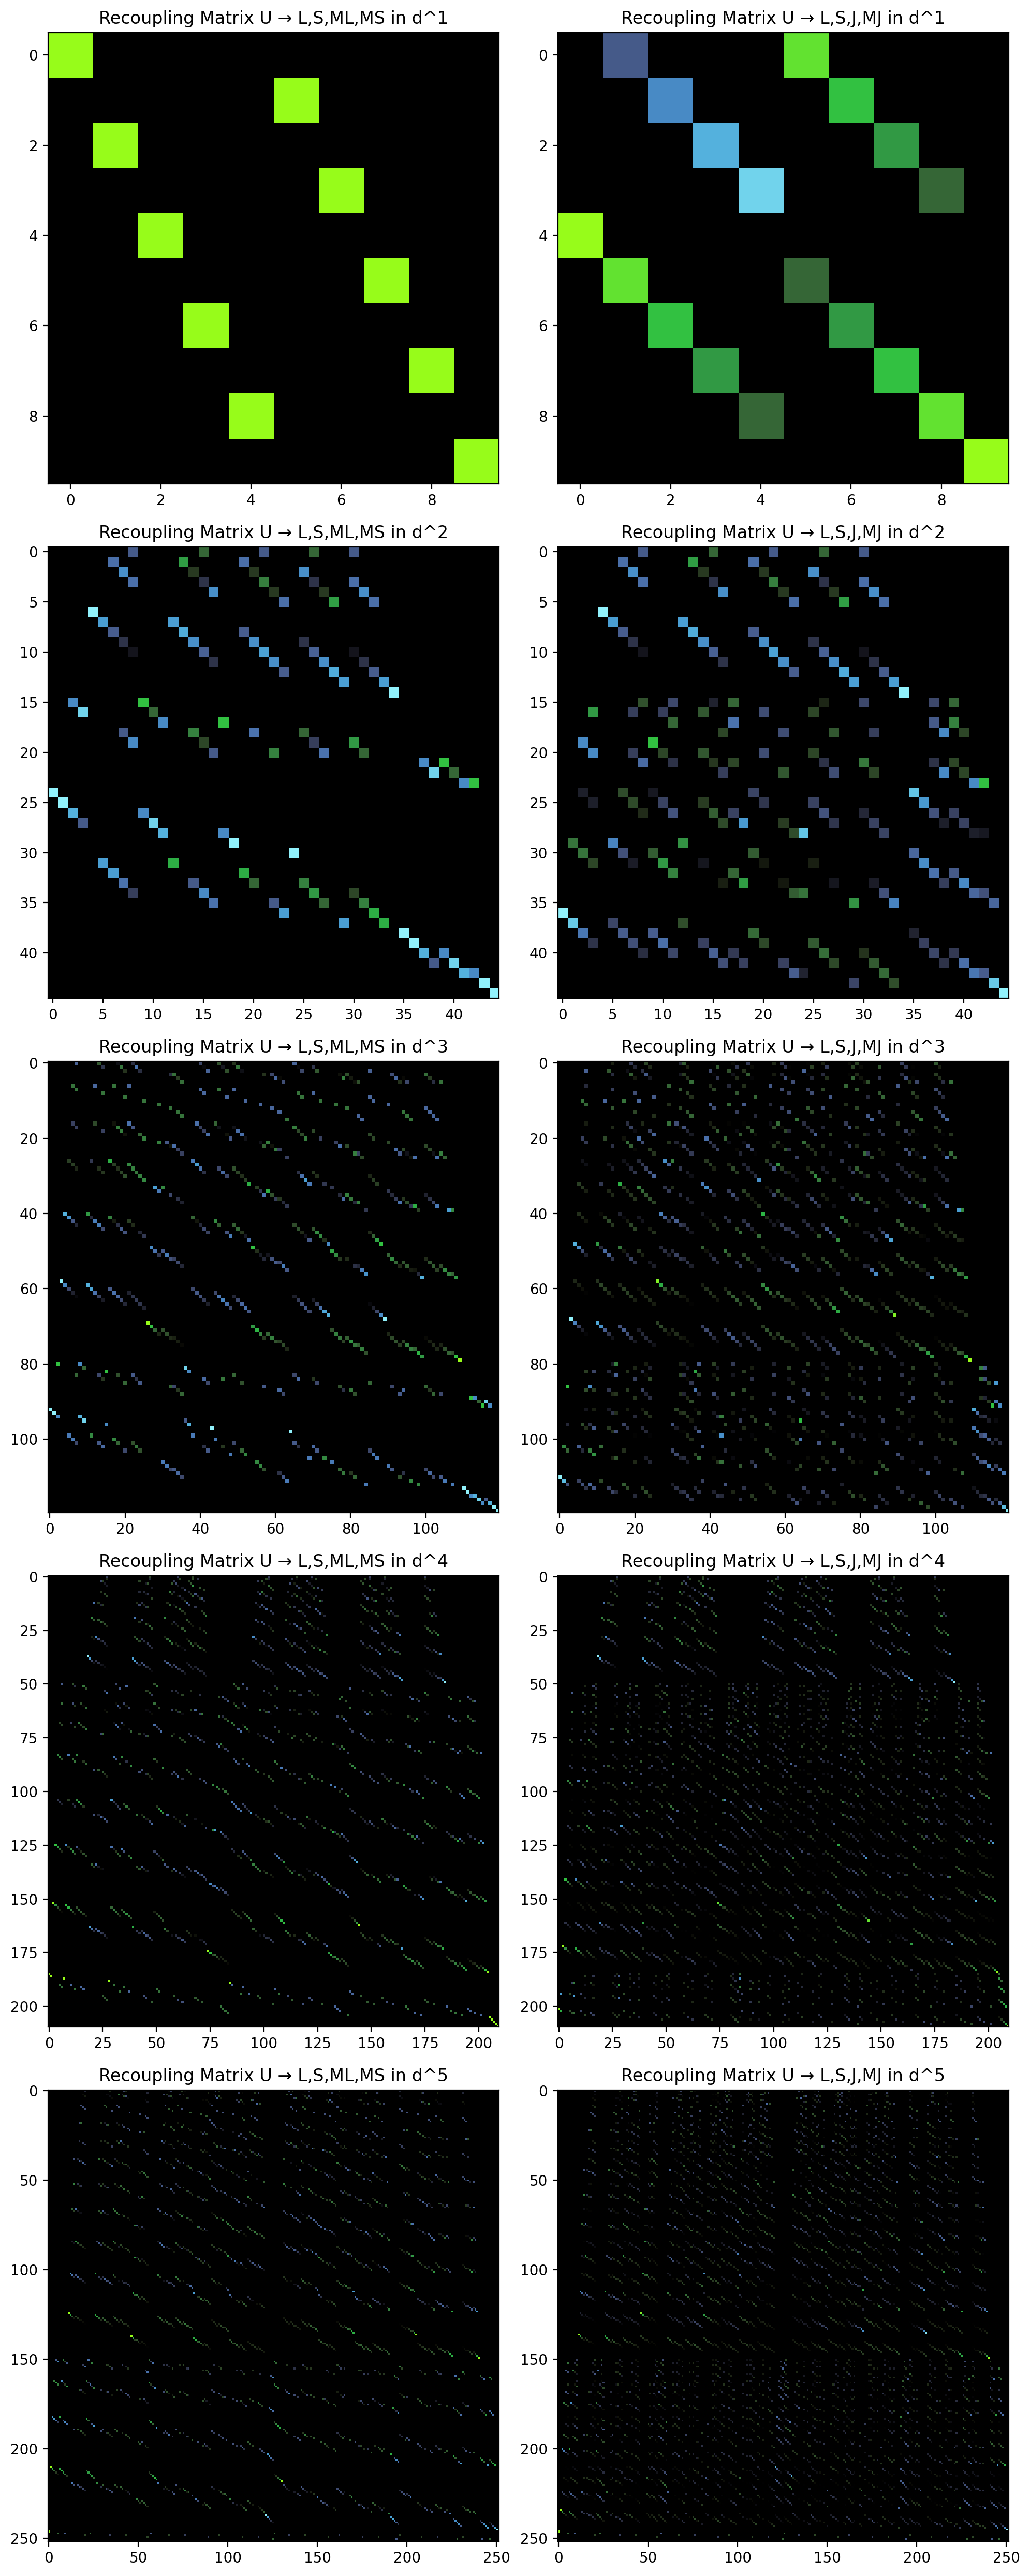

In [55]:
fig, axes = plt.subplots(nrows=len(U_to_LS_matrices), ncols=2,figsize=(10,5*len(U_to_LS_matrices)))
for idx, num_electrons in enumerate(sorted(U_to_LS_matrices.keys())):
    axes[idx][0].imshow(np.array(U_to_LS_matrices[num_electrons][0], dtype=np.float64),
               interpolation=None,
               vmin=-1, vmax=1,
               cmap=cm.seaweed)
    axes[idx][0].set_title('Recoupling Matrix U → L,S,ML,MS in d^%d' % num_electrons)
    axes[idx][1].imshow(np.array(U_to_LSJ_matrices[num_electrons][0], dtype=np.float64),
               interpolation=None,
               vmin=-1, vmax=1,
               cmap=cm.seaweed)
    axes[idx][1].set_title('Recoupling Matrix U → L,S,J,MJ in d^%d' % num_electrons)
plt.tight_layout()
plt.savefig('/Users/juan/Temp/recoupling_matrices.pdf')
plt.savefig('/Users/juan/Temp/recoupling_matrices.png')
plt.show()

In [ ]:
pkg = {'U->LSMLMS': U_to_LS_matrices,
      'U->LSJMJ': U_to_LSJ_matrices}
pickle.dump()

In [48]:
# det check
for num_electrons in U_to_LS_matrices:
    matrix = np.array(U_to_LS_matrices[num_electrons][0],dtype=np.float64)
    print(num_electrons, np.linalg.det(matrix))
    matrix = np.array(U_to_LSJ_matrices[num_electrons][0],dtype=np.float64)
    print(num_electrons, np.linalg.det(matrix))

2 1.0000000000000002
2 0.9999999999999999
3 -0.999999999999998
3 -1.000000000000002
4 0.9999999999999973
4 -0.9999999999999944
5 1.0000000000000142
5 1.0000000000000127


In [ ]:
from tqdm import tqdm_notebook
num_cores = 10

In [63]:
lstring = 'd'
pickle_one_LSMLMS = './data/U_to_LSMLMS_matrices_%s.pkl' % lstring
pickle_two_LSJMJ = './data/U_to_LSJMJ_matrices_%s.pkl' % lstring
with open(pickle_one_LSMLMS,'rb') as file:
    U_to_LSMLMS_matrices = pickle.load(file)
with open(pickle_two_LSJMJ,'rb') as file:
    U_to_LSJMJ_matrices = pickle.load(file)

In [67]:
U_to_LSMLMS_matrices[1][0]

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [ ]:
U_to_LSMLMS_matrices[1][0]

In [86]:
lstring = 'p'
pickle_one_LSMLMS = './data/U_to_LSMLMS_matrices_%s.pkl' % lstring
pickle_two_LSJMJ = './data/U_to_LSJMJ_matrices_%s.pkl' % lstring
with open(pickle_one_LSMLMS,'rb') as file:
    U_to_LSMLMS_matrices = pickle.load(file)
with open(pickle_two_LSJMJ,'rb') as file:
    U_to_LSJMJ_matrices = pickle.load(file)

In [101]:
display(U_to_LSMLMS_matrices[1][0])
display(U_to_LSMLMS_matrices [5][0])
display(U_to_LSJMJ_matrices[1][0])
display(U_to_LSJMJ_matrices[5][0])

Matrix([
[1, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0],
[0, 1, 0, 0, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 1]])

Matrix([
[-1,  0,  0,  0,  0,  0],
[ 0, -1,  0,  0,  0,  0],
[ 0,  0, -1,  0,  0,  0],
[ 0,  0,  0, -1,  0,  0],
[ 0,  0,  0,  0, -1,  0],
[ 0,  0,  0,  0,  0, -1]])

Matrix([
[0, -sqrt(3)/3,          0, sqrt(6)/3,         0, 0],
[0,          0, -sqrt(6)/3,         0, sqrt(3)/3, 0],
[1,          0,          0,         0,         0, 0],
[0,  sqrt(6)/3,          0, sqrt(3)/3,         0, 0],
[0,          0,  sqrt(3)/3,         0, sqrt(6)/3, 0],
[0,          0,          0,         0,         0, 1]])

Matrix([
[ 0,  sqrt(3)/3,          0, -sqrt(6)/3,          0,  0],
[ 0,          0,  sqrt(6)/3,          0, -sqrt(3)/3,  0],
[-1,          0,          0,          0,          0,  0],
[ 0, -sqrt(6)/3,          0, -sqrt(3)/3,          0,  0],
[ 0,          0, -sqrt(3)/3,          0, -sqrt(6)/3,  0],
[ 0,          0,          0,          0,          0, -1]])

In [109]:
U_to_LSJMJ_matrices[1][0] == -U_to_LSJMJ_matrices[5][0]

True

In [105]:
display(U_to_LSMLMS_matrices[2][0])
display(U_to_LSMLMS_matrices[4][0])

display(U_to_LSJMJ_matrices[2][0])
display(U_to_LSJMJ_matrices[4][0])

Matrix([
[ 0,  0,  0,          0, -sqrt(3)/3,  0,          0,  sqrt(3)/3,          0, -sqrt(3)/3,          0,  0,  0,  0,  0],
[ 0,  0, -1,          0,          0,  0,          0,          0,          0,          0,          0,  0,  0,  0,  0],
[ 0,  0,  0, -sqrt(2)/2,          0,  0, -sqrt(2)/2,          0,          0,          0,          0,  0,  0,  0,  0],
[ 0,  0,  0,          0, -sqrt(6)/6,  0,          0, -sqrt(6)/3,          0, -sqrt(6)/6,          0,  0,  0,  0,  0],
[ 0,  0,  0,          0,          0,  0,          0,          0, -sqrt(2)/2,          0, -sqrt(2)/2,  0,  0,  0,  0],
[ 0,  0,  0,          0,          0,  0,          0,          0,          0,          0,          0, -1,  0,  0,  0],
[-1,  0,  0,          0,          0,  0,          0,          0,          0,          0,          0,  0,  0,  0,  0],
[ 0, -1,  0,          0,          0,  0,          0,          0,          0,          0,          0,  0,  0,  0,  0],
[ 0,  0,  0,          0,          0, -1,       

Matrix([
[0, 0, 0, 0,          0, -sqrt(3)/3,         0, sqrt(3)/3,          0, 0, -sqrt(3)/3,         0, 0, 0, 0],
[0, 0, 0, 1,          0,          0,         0,         0,          0, 0,          0,         0, 0, 0, 0],
[0, 0, 0, 0,  sqrt(2)/2,          0, sqrt(2)/2,         0,          0, 0,          0,         0, 0, 0, 0],
[0, 0, 0, 0,          0,  sqrt(6)/6,         0, sqrt(6)/3,          0, 0,  sqrt(6)/6,         0, 0, 0, 0],
[0, 0, 0, 0,          0,          0,         0,         0,  sqrt(2)/2, 0,          0, sqrt(2)/2, 0, 0, 0],
[0, 0, 0, 0,          0,          0,         0,         0,          0, 0,          0,         0, 1, 0, 0],
[1, 0, 0, 0,          0,          0,         0,         0,          0, 0,          0,         0, 0, 0, 0],
[0, 1, 0, 0,          0,          0,         0,         0,          0, 0,          0,         0, 0, 0, 0],
[0, 0, 1, 0,          0,          0,         0,         0,          0, 0,          0,         0, 0, 0, 0],
[0, 0, 0, 0, -sqrt(2)/2,    

Matrix([
[ 0,          0,  0,          0, -sqrt(3)/3,          0,          0,  sqrt(3)/3,          0, -sqrt(3)/3,          0,  0,          0,          0,  0],
[ 0,          0, -1,          0,          0,          0,          0,          0,          0,          0,          0,  0,          0,          0,  0],
[ 0,          0,  0, -sqrt(2)/2,          0,          0, -sqrt(2)/2,          0,          0,          0,          0,  0,          0,          0,  0],
[ 0,          0,  0,          0, -sqrt(6)/6,          0,          0, -sqrt(6)/3,          0, -sqrt(6)/6,          0,  0,          0,          0,  0],
[ 0,          0,  0,          0,          0,          0,          0,          0, -sqrt(2)/2,          0, -sqrt(2)/2,  0,          0,          0,  0],
[ 0,          0,  0,          0,          0,          0,          0,          0,          0,          0,          0, -1,          0,          0,  0],
[ 0,          0,  0,          0,  sqrt(6)/6, -sqrt(3)/3,          0,          0,          0

Matrix([
[0,          0,          0, 0,         0, -sqrt(3)/3,         0, sqrt(3)/3,         0,         0, -sqrt(3)/3,         0, 0,         0, 0],
[0,          0,          0, 1,         0,          0,         0,         0,         0,         0,          0,         0, 0,         0, 0],
[0,          0,          0, 0, sqrt(2)/2,          0, sqrt(2)/2,         0,         0,         0,          0,         0, 0,         0, 0],
[0,          0,          0, 0,         0,  sqrt(6)/6,         0, sqrt(6)/3,         0,         0,  sqrt(6)/6,         0, 0,         0, 0],
[0,          0,          0, 0,         0,          0,         0,         0, sqrt(2)/2,         0,          0, sqrt(2)/2, 0,         0, 0],
[0,          0,          0, 0,         0,          0,         0,         0,         0,         0,          0,         0, 1,         0, 0],
[0,          0,  sqrt(3)/3, 0,         0,  sqrt(6)/6,         0,         0,         0, sqrt(3)/3, -sqrt(6)/6,         0, 0,         0, 0],
[0, -sqrt(2)/2,   

In [135]:
perm

[0, 5, 4, 3, 2, 1, 6, 9, 8, 7, 14, 13, 12, 11, 10]

In [144]:
matrix_dim = len(U_to_LSJMJ_matrices[2][1])
perm = [U_to_LSJMJ_matrices[2][1].index((S, L, J, -MJ, W)) for (S, L, J, MJ, W) in U_to_LSJMJ_matrices[2][1]]
unit_vectors = [[1 if (j==i) else 0 for j in range(matrix_dim)] for i in range(matrix_dim)]
perm_matrix = sp.Matrix([unit_vectors[idx] for idx in perm])
conjured = U_to_LSJMJ_matrices[4][0] * perm_matrix.T

In [148]:
U_to_LSJMJ_matrices[2][0].T * conjured

Matrix([
[-1,    0,  0,  0,  0,  0,  0,  0,  0,    0,  0,  0,  0,  0,    0],
[ 0,    0,  0,  0,  0, -1,  0,  0,  0,    0,  0,  0,  0,  0,    0],
[ 0,    0,  0, -1,  0,  0,  0,  0,  0,    0,  0,  0,  0,  0,    0],
[ 0,    0,  0,  0,  0,  0, -1,  0,  0,    0,  0,  0,  0,  0,    0],
[ 0,  2/3,  0,  0,  0,  0,  0,  0,  0, -2/3,  0,  0,  0,  0, -1/3],
[ 0,    0,  0,  0, -1,  0,  0,  0,  0,    0,  0,  0,  0,  0,    0],
[ 0,    0, -1,  0,  0,  0,  0,  0,  0,    0,  0,  0,  0,  0,    0],
[ 0, -2/3,  0,  0,  0,  0,  0,  0,  0, -1/3,  0,  0,  0,  0, -2/3],
[ 0,    0,  0,  0,  0,  0,  0,  0,  0,    0,  0,  0,  0, -1,    0],
[ 0, -1/3,  0,  0,  0,  0,  0,  0,  0, -2/3,  0,  0,  0,  0,  2/3],
[ 0,    0,  0,  0,  0,  0,  0,  0, -1,    0,  0,  0,  0,  0,    0],
[ 0,    0,  0,  0,  0,  0,  0,  0,  0,    0,  0,  0, -1,  0,    0],
[ 0,    0,  0,  0,  0,  0,  0, -1,  0,    0,  0,  0,  0,  0,    0],
[ 0,    0,  0,  0,  0,  0,  0,  0,  0,    0,  0, -1,  0,  0,    0],
[ 0,    0,  0,  0,  0,  0,  0,  0,  0, 

In [107]:
U_to_LSJMJ_matrices[2][0] + U_to_LSJMJ_matrices[4][0]

Matrix([
[0, 0,          0,          0, -sqrt(3)/3,             -sqrt(3)/3, 0, 2*sqrt(3)/3,  0,             -sqrt(3)/3, -sqrt(3)/3,         0,          0, 0, 0],
[0, 0,         -1,          1,          0,                      0, 0,           0,  0,                      0,          0,         0,          0, 0, 0],
[0, 0,          0, -sqrt(2)/2,  sqrt(2)/2,                      0, 0,           0,  0,                      0,          0,         0,          0, 0, 0],
[0, 0,          0,          0, -sqrt(6)/6,              sqrt(6)/6, 0,           0,  0,             -sqrt(6)/6,  sqrt(6)/6,         0,          0, 0, 0],
[0, 0,          0,          0,          0,                      0, 0,           0,  0,                      0, -sqrt(2)/2, sqrt(2)/2,          0, 0, 0],
[0, 0,          0,          0,          0,                      0, 0,           0,  0,                      0,          0,        -1,          1, 0, 0],
[0, 0,  sqrt(3)/3,          0,  sqrt(6)/6, -sqrt(3)/3 + sqrt(6)/6, 0,    

In [368]:
# num_electrons, l = 3, 2
# ham, basis_change, slater_dets = hamiltonian_CF_CR_SO_TO_Ubasis(num_electrons, 'O', l, sparse=False)
# LS_basis = LS_Ψs[num_electrons]

# slater_prelim = [[tuple(basis_change[q].dict.keys())[0][1:] for q in qet] for qet in slater_dets]
# explicit_slater_qets = OrderedDict()
# for permutation in permutations(range(num_electrons)):
#     permutation  = Permutation(permutation)
#     ε = permutation.signature()
#     for slater_nums in slater_prelim:
#         slater_key = sum(slater_nums,tuple())
#         if slater_key not in explicit_slater_qets:
#             explicit_slater_qets[slater_key] = Qet({})
#         aqnum = sum(permutation(slater_nums),tuple())
#         explicit_slater_qets[slater_key] += ε*Qet({aqnum:1})

# for slater_nums in slater_prelim:
#     slater_key = sum(slater_nums,tuple())
#     explicit_slater_qets[slater_key] = sp.S(1)/sp.sqrt(sp.factorial(num_electrons))*explicit_slater_qets[slater_key]

# def Ψ_cruncher(LS_qet_key, LS_qet, explicit_slater_qets):
#     LS_expansion = []
#     for qet_key, qet in explicit_slater_qets.items():
#         rc_coeff = braket(LS_qet,qet)
#         LS_expansion.append(rc_coeff)
#     return LS_expansion

# U_to_SL_matrix = []
# LS_qet_basis_list = []
# matrix_size = sum([len(term_qets) for term_qets in LS_basis.values()])
# num_matrix_elements = matrix_size**2
# LS_expansions = []
# pbar = tqdm(total=len(LS_basis))
# counter = 0

# for term, term_qets in LS_basis.items():
#     LS_expansion = Parallel(n_jobs = num_cores)(delayed(Ψ_cruncher)(LS_qet_key, LS_qet, explicit_slater_qets) for (LS_qet_key, LS_qet) in term_qets.items())
#     LS_expansions.extend(LS_expansion)
#     counter += 1
#     pbar.n = counter
#     pbar.display()
# for term, term_qets in LS_basis.items():
#     LS_qet_basis_list.extend([LS_qet_key  for (LS_qet_key, LS_qet) in term_qets.items()])
# U_to_SL_matrix = sp.Matrix(LS_expansions)


  0%|          | 0/8 [00:00<?, ?it/s]

In [372]:
# num_electrons, l = 6, 2
# ham, basis_change, slater_dets = hamiltonian_CF_CR_SO_TO_Ubasis(num_electrons, 'O', l, sparse=False)
# LS_basis = LS_Ψs[num_electrons]

# slater_prelim = [[tuple(basis_change[q].dict.keys())[0][1:] for q in qet] for qet in slater_dets]
# explicit_slater_qets = OrderedDict()
# for permutation in permutations(range(num_electrons)):
#     permutation  = Permutation(permutation)
#     ε = permutation.signature()
#     for slater_nums in slater_prelim:
#         slater_key = sum(slater_nums,tuple())
#         if slater_key not in explicit_slater_qets:
#             explicit_slater_qets[slater_key] = Qet({})
#         aqnum = sum(permutation(slater_nums),tuple())
#         explicit_slater_qets[slater_key] += ε*Qet({aqnum:1})

# for slater_nums in slater_prelim:
#     slater_key = sum(slater_nums,tuple())
#     explicit_slater_qets[slater_key] = sp.S(1)/sp.sqrt(sp.factorial(num_electrons))*explicit_slater_qets[slater_key]

# def Ψ_cruncher(LS_qet_key, LS_qet, explicit_slater_qets):
#     LS_expansion = []
#     for qet_key, qet in explicit_slater_qets.items():
#         rc_coeff = bbraket(LS_qet,qet)
#         LS_expansion.append(rc_coeff)
#     return LS_expansion

# U_to_SL_matrix = []
# LS_qet_basis_list = []
# matrix_size = sum([len(term_qets) for term_qets in LS_basis.values()])
# num_matrix_elements = matrix_size**2
# LS_expansions = []
# pbar = tqdm(total=len(LS_basis))
# counter = 0

# for term, term_qets in LS_basis.items():
#     LS_expansion = Parallel(n_jobs = num_cores)(delayed(Ψ_cruncher)(LS_qet_key, LS_qet, explicit_slater_qets) for (LS_qet_key, LS_qet) in term_qets.items())
#     LS_expansions.extend(LS_expansion)
#     counter += 1
#     pbar.n = counter
#     pbar.display()
# for term, term_qets in LS_basis.items():
#     LS_qet_basis_list.extend([LS_qet_key  for (LS_qet_key, LS_qet) in term_qets.items()])
# U_to_SL_matrix = sp.Matrix(LS_expansions)


  0%|          | 0/16 [00:00<?, ?it/s]

In [351]:
# for term, term_qets in LS_basis.items():
#     for (LS_qet_key, LS_qet) in term_qets.items():
#         break
# for qet_key, qet in explicit_slater_qets.items():
#     break

In [364]:
# def bbraket(lket, rket):
#     '''
#     Given  two  qets,  spanned  in  a  common orthonormal basis,
#     return the braket that corresponds to it.
#     Parameters
#     ----------
#     lket (qdef.Qet): assumed to be a ket, which is conjugated in
#     the function to give the bra.
#     rket (qdef.Qet): assumed to be a ket.
#     Returns
#     -------
#     <lket|rket> (sp.S)
#     '''
#     lket = lket.dict
#     rket = rket.dict
#     brket = sp.S(0)
#     common_keys = set(lket.keys()).intersection(set(rket.keys()))
#     for ckey in common_keys:
#         brket += sp.conjugate(lket[ckey]) * rket[ckey]
#     return brket
# def bbraket2(lket, rket):
#     '''
#     Given  two  qets,  spanned  in  a  common orthonormal basis,
#     return the braket that corresponds to it.
#     Parameters
#     ----------
#     lket (qdef.Qet): assumed to be a ket, which is conjugated in
#     the function to give the bra.
#     rket (qdef.Qet): assumed to be a ket.
#     Returns
#     -------
#     <lket|rket> (sp.S)
#     '''
#     lket = lket.dict
#     rket = rket.dict
#     brket = sp.S(0)
#     common_keys = set(lket.keys()).intersection(set(rket.keys()))
#     lketvals = np.array([sp.conjugate(lket[ckey]) for ckey in common_keys])
#     rketvals = np.array([rket[ckey] for ckey in common_keys])
#     return np.sum(lketvals*rketvals)
#     for ckey in common_keys:
#         brket += sp.conjugate(lket[ckey]) * rket[ckey]
#     return brket

In [362]:
# %%timeit
# braket(LS_qet, qet)

229 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [365]:
# %%timeit
# bbraket(LS_qet, qet)

22.8 ms ± 961 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [366]:
# %%timeit
# bbraket2(LS_qet, qet)

26.5 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [360]:
# bbraket2(LS_qet, qet)

-1

In [345]:
# %%timeit
# bbraket(LS_qet, qet)

25.6 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [296]:
# num_electrons, l = 4, 2
# ham, basis_change, slater_dets = hamiltonian_CF_CR_SO_TO_Ubasis(num_electrons, 'O', l, sparse=False)
# LS_basis = LS_Ψs[num_electrons]

# slater_prelim = [[tuple(basis_change[q].dict.keys())[0][1:] for q in qet] for qet in slater_dets]
# explicit_slater_qets = OrderedDict()
# for permutation in permutations(range(num_electrons)):
#     permutation  = Permutation(permutation)
#     ε = permutation.signature()
#     for slater_nums in slater_prelim:
#         slater_key = sum(slater_nums,tuple())
#         if slater_key not in explicit_slater_qets:
#             explicit_slater_qets[slater_key] = Qet({})
#         aqnum = sum(permutation(slater_nums),tuple())
#         explicit_slater_qets[slater_key] += ε*Qet({aqnum:1})

# for slater_nums in slater_prelim:
#     slater_key = sum(slater_nums,tuple())
#     explicit_slater_qets[slater_key] = sp.S(1)/sp.sqrt(sp.factorial(num_electrons))*explicit_slater_qets[slater_key]

# def Ψ_cruncher(LS_qet_key, LS_qet, explicit_slater_qets):
#     LS_expansion = []
#     for qet_key, qet in explicit_slater_qets.items():
#         rc_coeff = braket(LS_qet,qet)
#         LS_expansion.append(rc_coeff)
#     return LS_expansion

# U_to_SL_matrix_4 = []
# LS_qet_basis_list = []
# matrix_size = sum([len(term_qets) for term_qets in LS_basis.values()])
# num_matrix_elements = matrix_size**2
# LS_expansions = []
# pbar = tqdm(total=len(LS_basis))
# counter = 0
# for term, term_qets in LS_basis.items():
#     LS_expansion = Parallel(n_jobs = num_cores)(delayed(Ψ_cruncher)(LS_qet_key, LS_qet, explicit_slater_qets) for (LS_qet_key, LS_qet) in term_qets.items())
#     LS_expansions.extend(LS_expansion)
#     counter += 1
#     pbar.n = counter
#     pbar.display()
# for term, term_qets in LS_basis.items():
#     LS_qet_basis_list.extend([LS_qet_key  for (LS_qet_key, LS_qet) in term_qets.items()])
# U_to_SL_matrix_4 = sp.Matrix(LS_expansions)


  0%|          | 0/16 [00:00<?, ?it/s]

In [301]:
# U_to_SL_matrix_4.rows

210

### Tanabe - Sugano diagram with ζ=0

In [133]:
hf_free_ions = pd.read_pickle('./data/brik_ma_cowan.pkl')

In [141]:
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
import h5py

disambiguate = False
data_folder = './data/eigen_ions_SLMSML/'
energy_h5_file = './data/tsk_diag_withSO_HF-SLMSML-final-highres.h5'

def progress(total):
    num_done = len([f for f in os.listdir(data_folder) if 'h5' in f])
    print("%.1f" % (num_done/total*100))

In [145]:
Dq = sp.Symbol('Dq')
Dqs = np.linspace(-6,6,481)
l = 2
def ion_solver(B, C, ζ, num_electrons, element, charge):
    F2 = 49*B + 7*C
    F4 = 63*C/5
    eigen_fname = os.path.join(data_folder, '%s-%d.h5' % (element, charge))
    ham, basis_change, slater_dets = hamiltonian_CF_CR_SO_TO_Ubasis(num_electrons, 'O', l, sparse=False)
    LS_Ψs = SMSLML_gen(num_electrons)
    basis_changers = {'SLMSML': U_to_LS(num_electrons, basis_change, LS_Ψs[num_electrons], slater_dets),}
    ham = basis_changers['SLMSML'][0] * ham * basis_changers['SLMSML'][0].T
    ham = sp.simplify(ham)

    matrixmah = ham.subs({sp.Symbol('B_{4,0}'): 21*Dq, sp.Symbol('F^{(0)}'): 0})
    subs = {
                    sp.Symbol('F^{(2)}'): F2,
                    sp.Symbol('F^{(4)}'): F4,
                    sp.Symbol('\\alpha_T'): 0,
                    sp.Symbol('\\zeta_{SO}'): ζ
                    }
    matrixmah = matrixmah.subs(subs)

    mfun = sp.lambdify(Dq, matrixmah)
    eigenstates = []
    eigenvalues = []
    eigensystems = []
    for aDq in Dqs:
        nummatrix = mfun(aDq*B)
        nummatrix = np.array(nummatrix, dtype=np.float64)
        eigensys = np.linalg.eigh(nummatrix)
        eigensystems.append(eigensys)
        eigenstates.append(eigensys[1])
        eigenvalues.append(eigensys[0])
    eigenstates = np.array(eigenstates)
    eigenvalues = np.array(eigenvalues)

    with h5py.File(eigen_fname,'w') as eigen_h5:
        eigen_h5.create_dataset('/eigenstates',data=eigenstates)
        eigen_h5.create_dataset('/energies',data=eigenvalues)
        eigen_h5.create_dataset('/Dqs_in_cm^-1',data=Dqs*B)
        eigen_h5.create_dataset('/B',data=B)
        eigen_h5.create_dataset('/C',data=C)
        eigen_h5.create_dataset('/zeta',data=ζ)
    progress(total_jobs)
    return eigensystems

In [ ]:
jobs = []
total_jobs = 0
for index, row in hf_free_ions.iterrows():
    num_electrons = row['ndN']
    B, C = row['B/cm^-1'], row['C/cm^-1']
    ζ = row['ζd/cm^-1']
    element = row['Element']
    if element != 'Cr':
        print(element)
        continue
    charge = row['Charge']
    jobs.append((B, C, ζ, num_electrons, element, charge))
    if not any(list(map(np.isnan, [B, C, ζ]))):
        total_jobs += 1
print("Total jobs to run = %d" % total_jobs)
print("Calculating eigensystems ...")
all_eigensystems = Parallel(n_jobs=num_cores)(delayed(ion_solver)(*job) for job in jobs)
print("Finished eigensystem calculation ...")

In [ ]:
ζ = 0

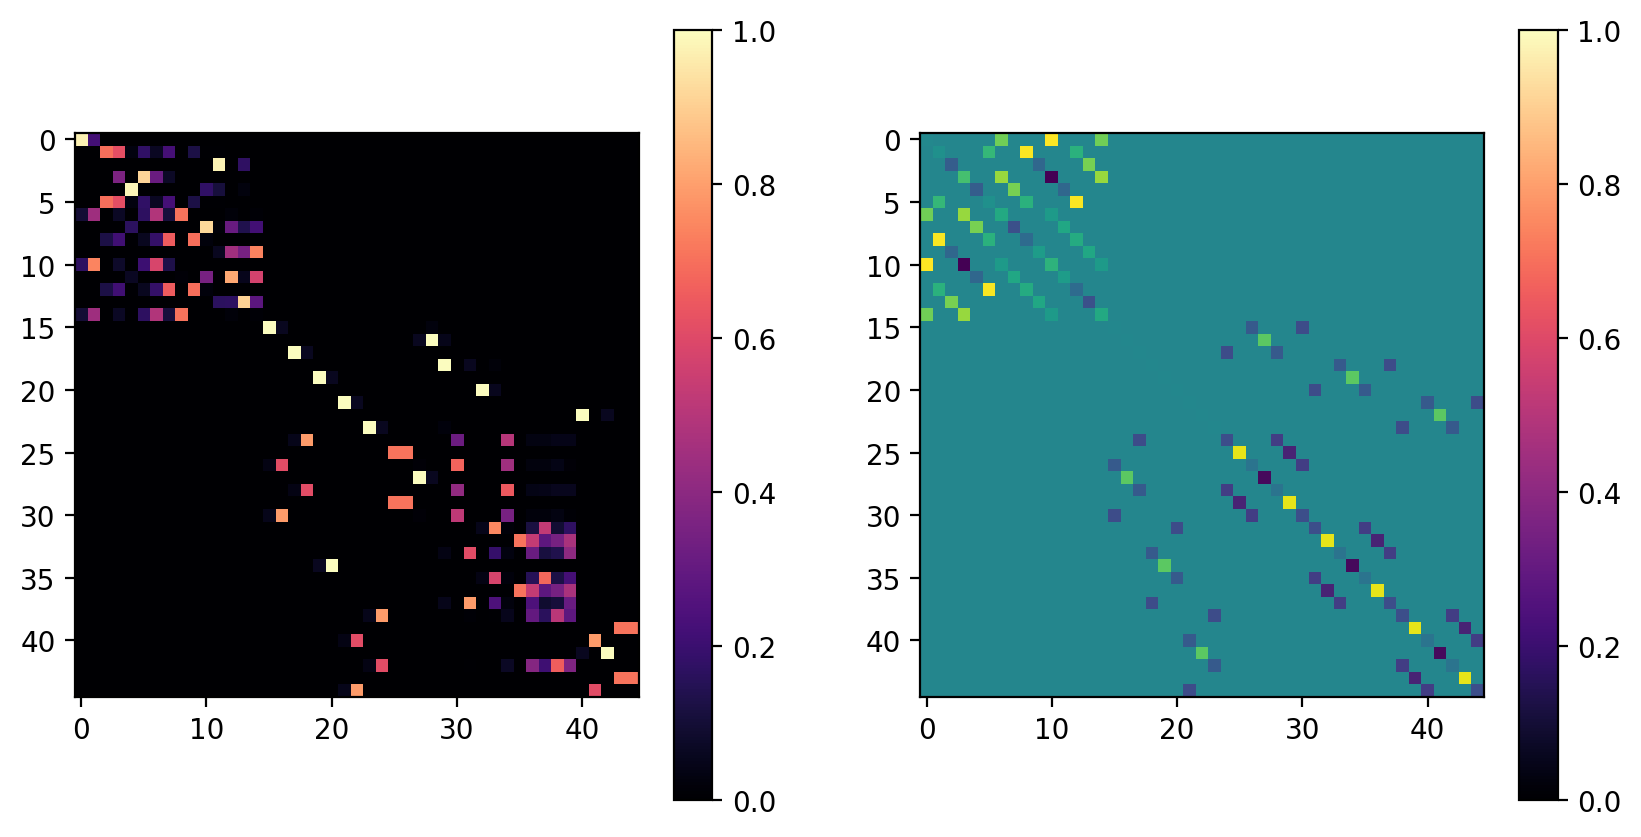

In [132]:
eigstates = np.linalg.eig(mfun(1))[1]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
im = ax[0].imshow(np.abs(eigstates),vmin=0, vmax=1, cmap='magma')
plt.colorbar(im, ax=ax[0])
ax[1].imshow(mfun(1000))
plt.colorbar(im, ax=ax[1])
plt.show()

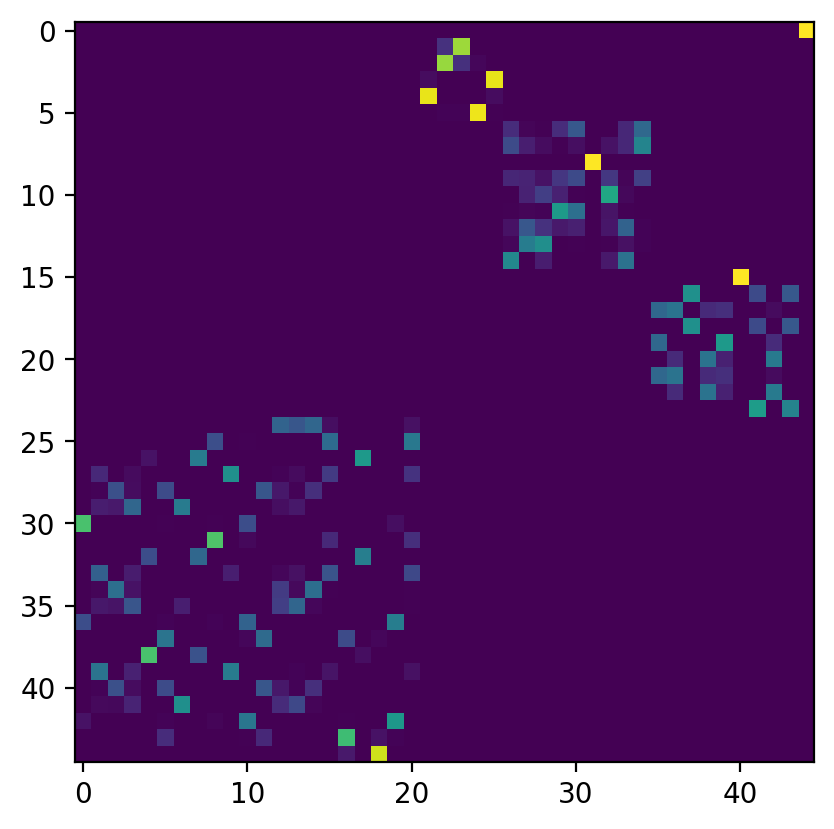

In [85]:
plt.figure()
plt.imshow(np.real(eigenstates[240]**2))
plt.show()

In [ ]:
for eigenstate in eigenstates[240]:
    print(eigenstate)
    print(np.max(eigenstate**2))

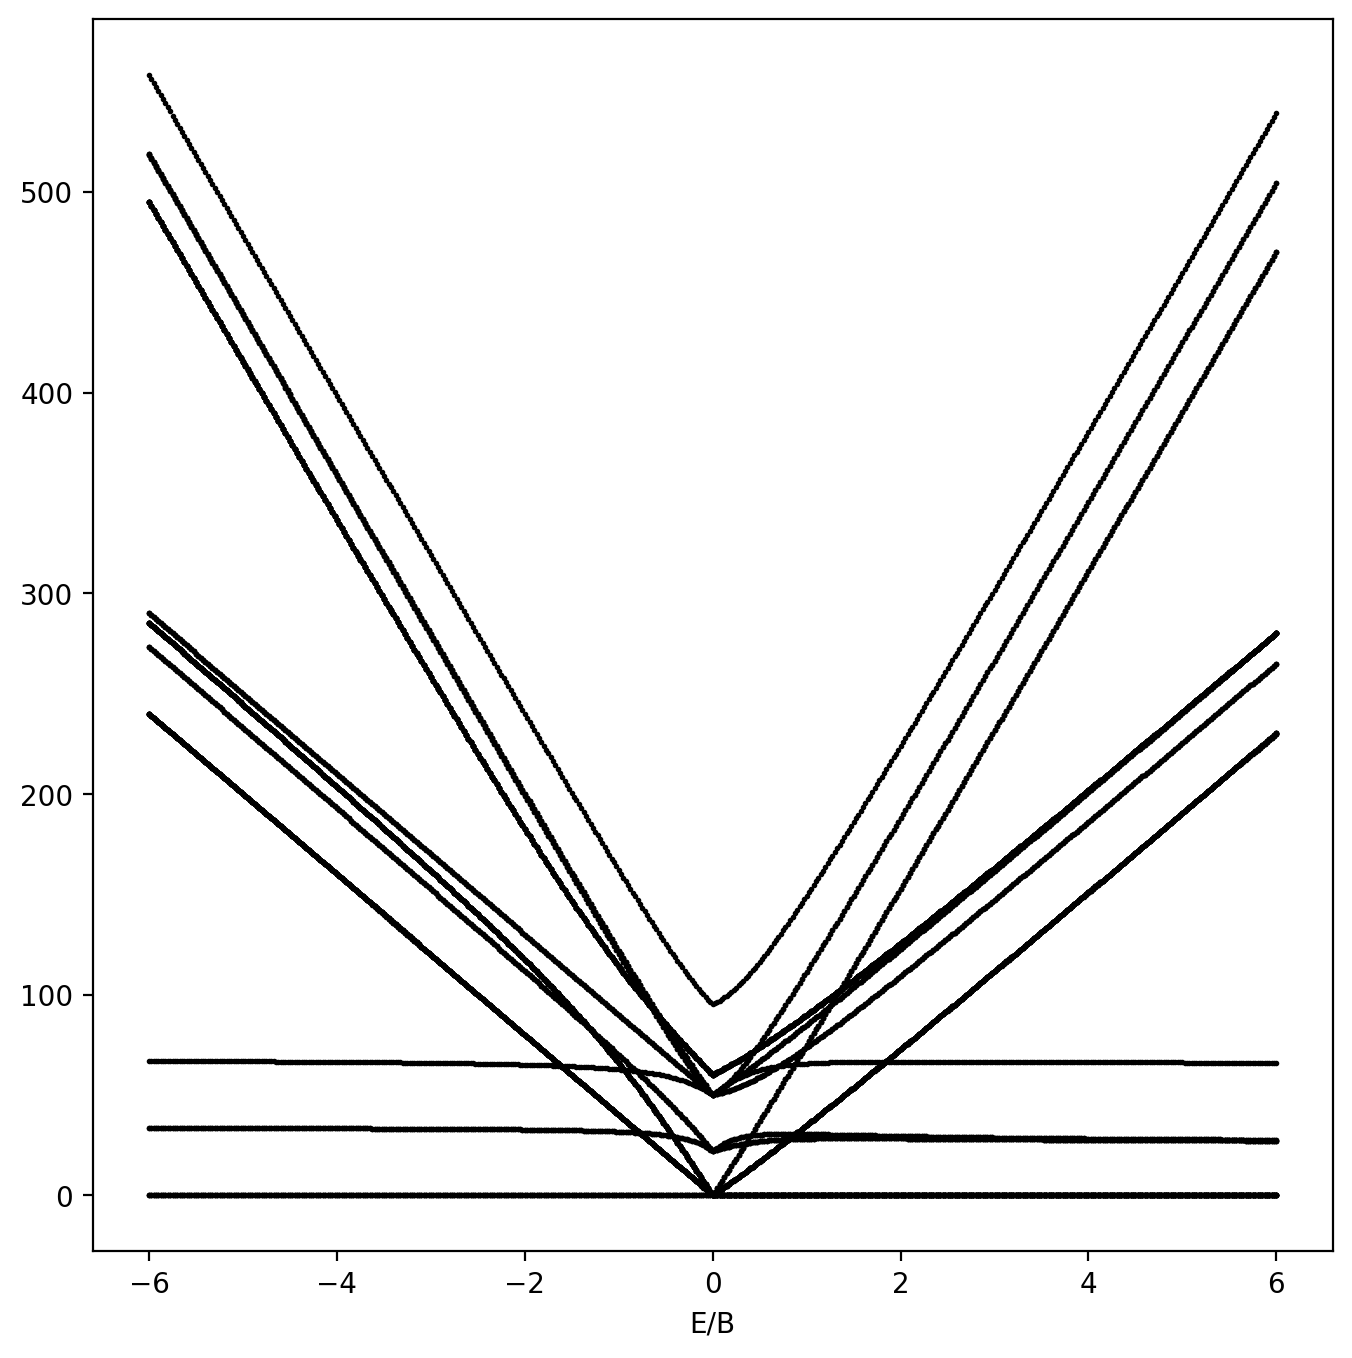

In [77]:
plt.figure(figsize=(8,8))
for row, Dq in zip(eigenvalues, Dqs):
    row = row-np.min(row)
    plt.plot([Dq]*len(row), row,'ko', ms=1)
plt.xlabel('Dq/B')
plt.xlabel('E/B')
plt.show()

In [ ]:
!beep